<a href="https://colab.research.google.com/github/lewfish/mlx/blob/lf%2Fpascal-multi/mlx/nbs/pascal_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.vision import *
from fastai.vision.learner import *
from fastai import *
from pathlib import Path
import json
import collections
import numpy as np
import torchvision

from mlx.od.pascal_multi import *


In [2]:
remote = False
path = Path('/opt/data/pascal2007/')

if remote:
    !wget -O /tmp/pascal.tar http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    !mkdir /tmp/pascal
    !tar -xf /tmp/pascal.tar -C /tmp/pascal
    !wget -O /tmp/pascal_json.zip https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    !unzip /tmp/pascal_json.zip -d /tmp/pascal/

    path = Path('/tmp/pascal/')


In [3]:
img_path = path/'VOCdevkit/VOC2007/JPEGImages'

trn_path = path/'PASCAL_VOC/pascal_train2007.json'
trn_images, trn_lbl_bbox = get_annotations(trn_path)
trn_img2bbox = dict(zip(trn_images, trn_lbl_bbox))

import json
with open(trn_path) as f:
    d = json.load(f)
    cls2id = dict([(x['name'], x['id']) for x in d['categories']])

val_path = path/'PASCAL_VOC/pascal_val2007.json'
val_images, val_lbl_bbox = get_annotations(val_path)
val_img2bbox = dict(zip(val_images, val_lbl_bbox))

img2bbox = {**trn_img2bbox, **val_img2bbox}

def get_y_func(o):
  return img2bbox[o.name]


In [4]:
# Use part of dataset
# I tried using use_partial_data(0.1) but this made .label_from_func crash.
data = ObjectItemList.from_folder(img_path)
data_prop = 1.0
num_items = round(len(data) * data_prop)
data = data[:num_items]
data = data.split_by_files(val_images) \
        .label_from_func(get_y_func) \
        .transform(get_transforms(), tfm_y=True, size=224) \
        .databunch(bs=16, collate_fn=bb_pad_collate) \
        .normalize(imagenet_stats)


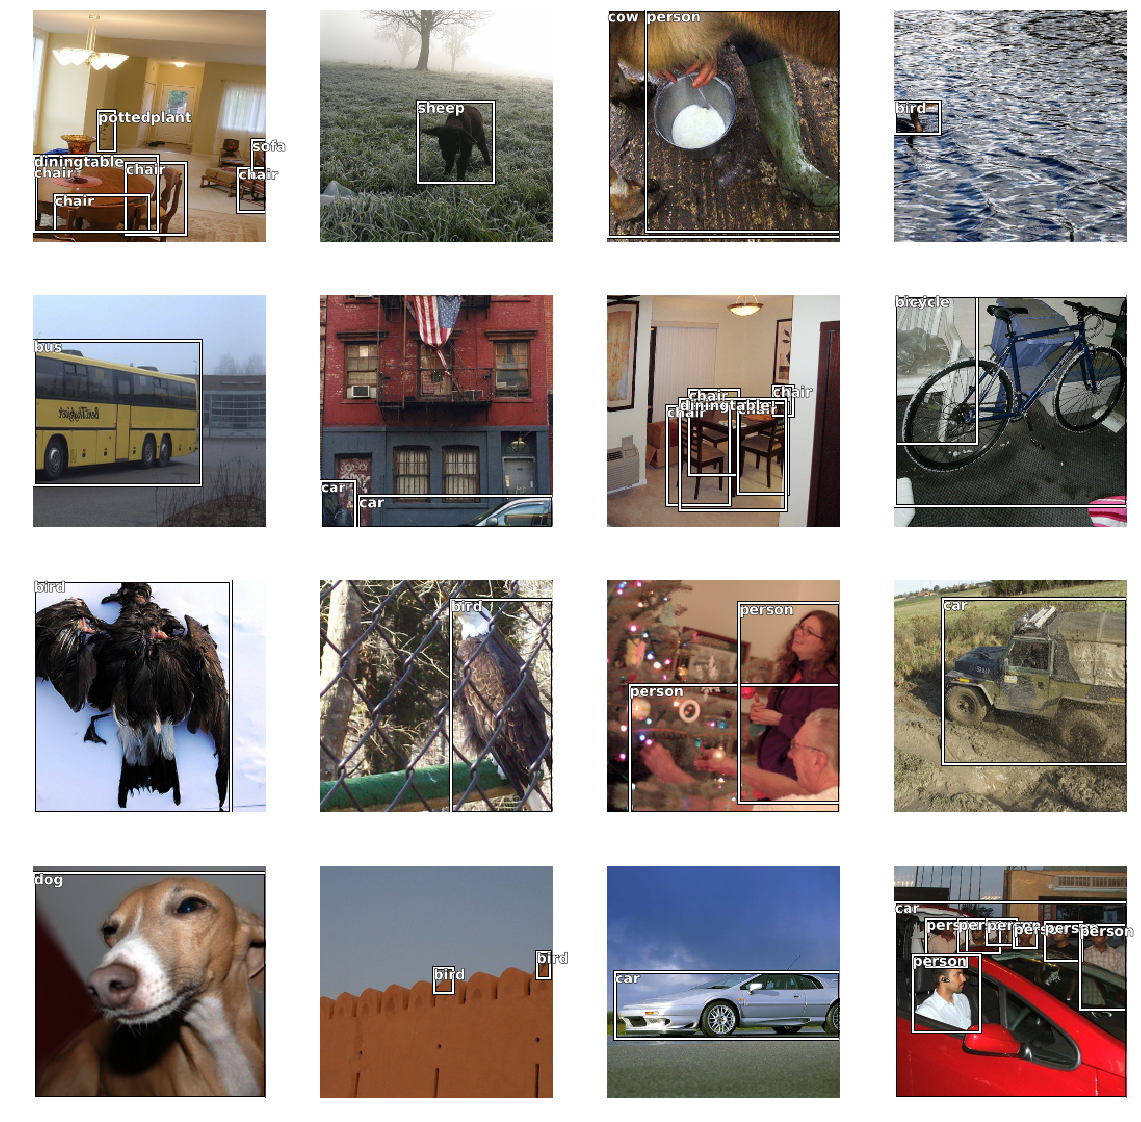

In [5]:
data.show_batch()

In [90]:
class LocalizationModel(nn.Module):
    def __init__(self, num_classes):
        super(LocalizationModel, self).__init__()
        self.num_classes = num_classes
  
        resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet_body = nn.Sequential(*(list(resnet.children())[:-1]))
  
        self.num_hidden = 512
        self.num_outs = 4 + num_classes
        # Can we infer the size of the output of self.resnet?
        self.fc1 = nn.Linear(512, self.num_hidden)
        self.bn1 = nn.BatchNorm1d(self.num_hidden)
        self.fc2 = nn.Linear(self.num_hidden, self.num_outs)

    def forward(self, x):
       x = self.resnet_body(x)
       x = torch.flatten(x, start_dim=1)
       x = self.fc1(x)
       x = nn.functional.relu(x)
       x = self.bn1(x)
       x = self.fc2(x)
       box, classes = (x[:, 0:4], x[:, 4:])
       box = torch.tanh(box)
       boxes = torch.unsqueeze(box, 1)
       classes = torch.unsqueeze(classes, 1)
       out = [boxes, classes]
       return out
    
    def freeze_body(self):
      for p in self.resnet_body.parameters():
        p.requires_grad = False
    
    def unfreeze(self):
      for p in self.parameters():
        p.requires_grad = True
    

num_classes = len(data.classes)
model = LocalizationModel(num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 79009089.84it/s]


In [0]:
def class_accuracy(out, boxes, classes):
  b, c = out
  c = c[:, 0, :]
  classes = classes[:, 0]
  return accuracy(c, classes)

def box_error(out, boxes, classes):
  b, c = out
  return mean_absolute_error(b, boxes)

def box_class_loss(out, boxes, classes):
  b, c = out
  class_loss = nn.functional.cross_entropy(c[:, 0, :], classes[:, 0])
  box_loss = nn.functional.l1_loss(b, boxes)
  return class_loss + box_loss

In [0]:
learn = Learner(data, model, loss_func=box_class_loss, metrics=[class_accuracy, box_error])
model.freeze_body()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


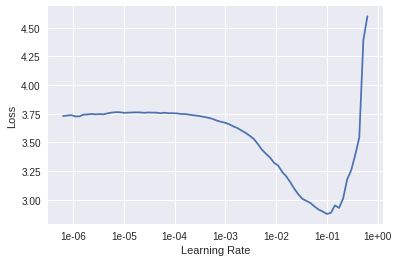

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)


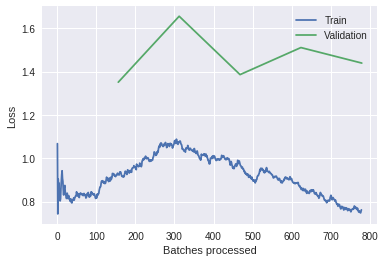

In [0]:
learn.recorder.plot_losses()

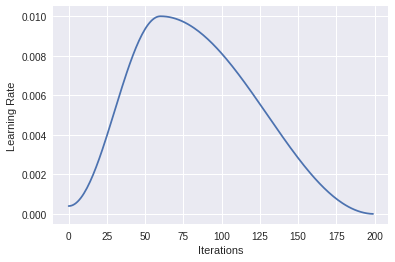

In [0]:
learn.recorder.plot_lr()

In [0]:
model.unfreeze()
learn.fit_one_cycle(1, 1e-3)

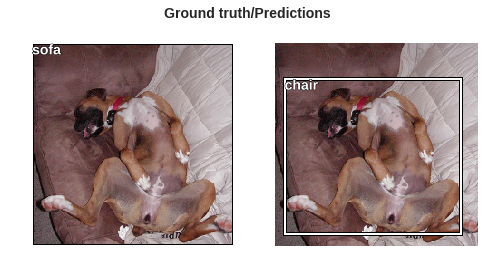

In [0]:
# manually plot prediction and ground truth
model.eval()
s = learn.data.valid_ds[113]

x = s[0].data.unsqueeze(0).cuda()
out = model(x)
box, classes = out
box, classes = box[0].cpu(), classes[0].cpu()
classes = classes.argmax(dim=1)
single_out = (box, classes)
pred = learn.data.valid_ds.y.reconstruct(single_out, s[0])

data.show_xyzs(s[0:1], s[1:2], [pred])


In [0]:
# Fix problems with fastai

def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False) -> List[Tensor]:
    "Return output of the model on one batch from `ds_type` dataset."
    if batch is not None: xb,yb = batch
    else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
    cb_handler = CallbackHandler(self.callbacks)
    xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
    preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
    box, probs = preds[0]
    probs = probs.argmax(dim=2)
    res = (box, probs)
    # res = _loss_func2activ(self.loss_func)(preds[0])
    if not reconstruct: return res
    res = res.detach().cpu()
    ds = self.dl(ds_type).dataset
    norm = getattr(self.data, 'norm', False)
    if norm and norm.keywords.get('do_y',False):
        res = self.data.denorm(res, do_x=True)
    return [ds.reconstruct(o) for o in res]

def predict(self, item:ItemBase, **kwargs):
    "Return predicted class, label and probabilities for `item`."
    batch = self.data.one_item(item)
    res = self.pred_batch(batch=batch)
    pred = (res[0][0], res[1][0])
    x = batch[0]
    # pred,x = res[0],batch[0]
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): pred = self.data.denorm(pred)
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(pred, **kwargs)
    out = ds.y.reconstruct(pred, ds.x.reconstruct(x[0])) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return out, pred, res[0][0]
  
import types
learn.predict = types.MethodType(predict, learn)
learn.pred_batch = types.MethodType(pred_batch, learn)

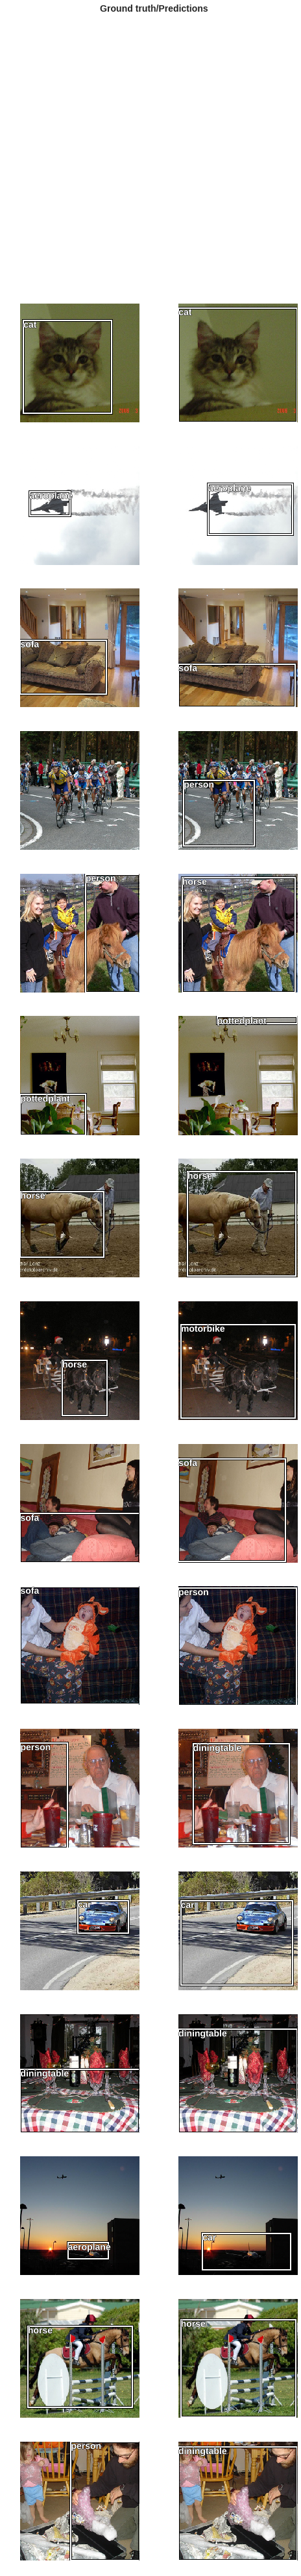

In [0]:
learn.show_results(rows=16)

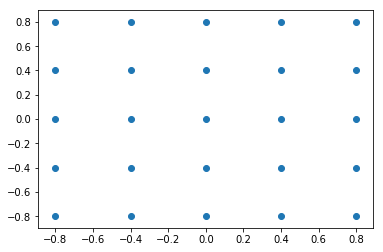

In [6]:
# make anchors
grid_size = 5
img_size = 2.0
cell_size = img_size / grid_size
# proportion of cell_size to use for anchor
# anchor_sizes = [(2, 2), (3, 1), (1, 3)]
# anchor_sizes = [(4, 4), (6, 2), (2, 6)]
anchor_sizes = [(4, 4), (6, 2), (2, 6), (2, 2), (3, 1), (1, 3)]

centers = []
for x in np.arange(cell_size/2.0 - 1, img_size - 1, cell_size):
  for y in np.arange(cell_size/2.0 - 1, img_size - 1, cell_size):
    centers.append((x, y))


# centers = [(0, 0)]
anchors = []
for x, y in centers:
  for h, w in anchor_sizes:
    a_h = cell_size * h
    a_w = cell_size * w
    a = [y-a_h/2, x-a_w/2, y+a_h/2, x+a_w/2]
    a = np.clip(a, -1, 1)
    anchors.append(a)

plt.scatter([c[0] for c in centers], [c[1] for c in centers])
plt.grid(False)
plt.show()


In [7]:
from shapely import geometry

def box2shapely(box):
  ymin, xmin, ymax, xmax = box
  return geometry.box(xmin, ymin, xmax, ymax)

def iou(a, b):
  i = a.intersection(b)
  u = a.union(b)
  return i.area / u.area

shp_anchors = [box2shapely(a) for a in anchors]

ModuleNotFoundError: No module named 'shapely'

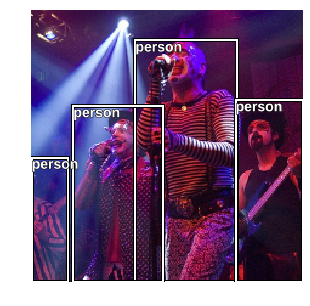

In [140]:
im_ind = 31
x, y = data.valid_ds[im_ind]
boxes, classes = y.data
shp_boxes = [box2shapely(b) for b in boxes]

bb = ImageBBox.create(*x.size, anchors, scale=False)
# x.show(y=bb, figsize=(5, 5))
x.show(y=y, figsize=(5, 5))

In [141]:
iou_thresh = 0.5

box2anchors = {}
for box_ind, b in enumerate(shp_boxes):
  ious = np.array([iou(a, b) for a in shp_anchors])
  match_inds = np.argwhere(ious > iou_thresh)[:, 0]
  box2anchors[box_ind] = match_inds
  
print(box2anchors)

{0: array([67, 73, 79, 85]), 1: array([133, 139, 141, 142, 145]), 2: array([18, 24, 43, 49, 51, 52, 55]), 3: array([22, 28])}


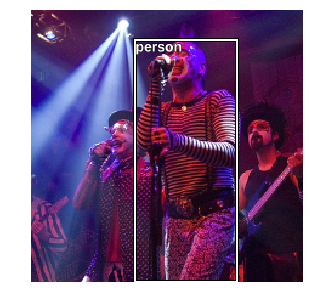

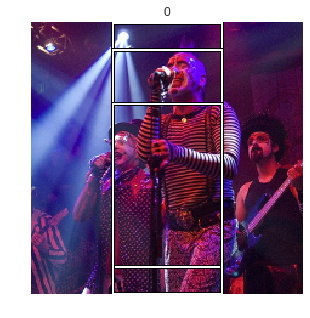

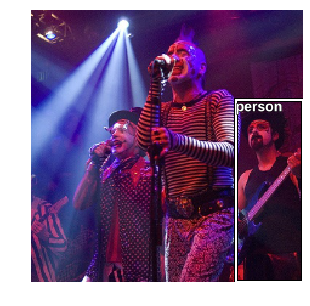

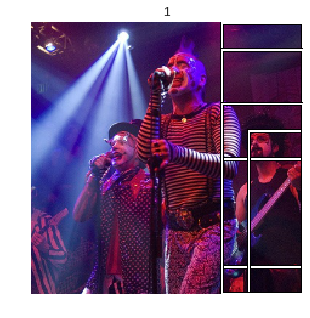

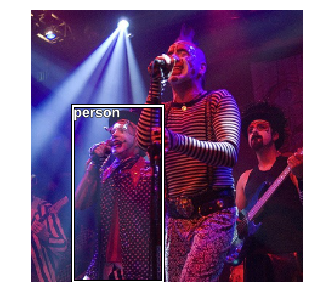

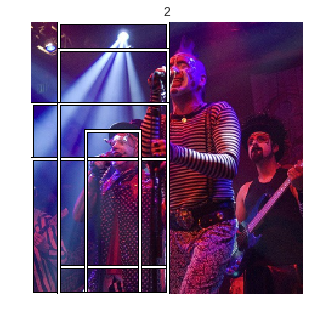

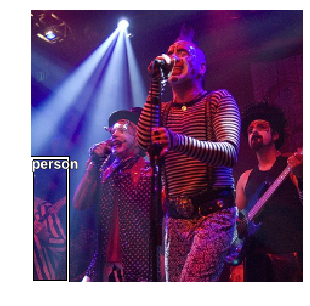

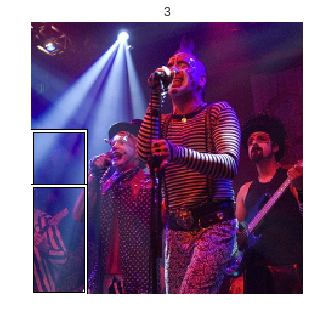

In [142]:
for box_ind, anchor_inds in box2anchors.items():
  match_anchors = [anchors[i] for i in anchor_inds]

  y_part = ImageBBox.create(
    *x.size, y.data[0][box_ind:box_ind+1], labels=y.data[1][box_ind:box_ind+1], 
    classes=data.classes, scale=False)
  x.show(y=y_part, figsize=(5, 5))
  
  anchor_bb = ImageBBox.create(*x.size, match_anchors, scale=False) if match_anchors else None
  x.show(y=anchor_bb, figsize=(5, 5), title=str(box_ind))
